In [1]:
dataset_this_month = '26 Feb to 20 Mar.xlsx'
dataset_pervious_month = 'Feb 2023.xlsx'

In [2]:
def categorize(list_of_num, n):
    """
    <What this function do>
    This function takes a list of numbers and categorize each number of them into A, B, C, D, F.
    
    <what it takes>
    it takes two parameters:
    1. list_of_num: the list of numbers you need to categorize 
    2. n: number of items in the list
    
    <what it returns>
    It returns a dictionary. In this dictionary, the ids of numbers in the passed list represented as a keys,
    and The categories values represented as values 

    """
    series = pd.Series(list_of_num)
    list_of_categories = ['A', 'B', 'C', 'D', 'F']
    list_of_categories = list_of_categories[: n]
    dict1 = {}
    categories_dict= {}
    
    dict1[list_of_categories[0]]= series.idxmax()
    series.drop(pd.Series(series).idxmax(), inplace = True)
    
    dict1[list_of_categories[1]]= series.idxmax()
    series.drop(pd.Series(series).idxmax(), inplace = True)
    
    try: 
        dict1[list_of_categories[2]]= series.idxmax()
        series.drop(pd.Series(series).idxmax(), inplace = True)
    except:
        pass
    
    try:
        dict1[list_of_categories[3]]= series.idxmax()
        series.drop(pd.Series(series).idxmax(), inplace = True)
    except:
        pass
    
    try:
        dict1[list_of_categories[1]]= series.idxmax()
        series.drop(pd.Series(series).idxmax(), inplace = True)
    except:
        pass
    for key, value in dict1.items():
        categories_dict[value] = key
    return categories_dict 

In [3]:
def Max_Min_Standardization(df, col):
    
    """
    <What this function do>
    This function standardizes the columns we need. It makes the scale of our column from 0 to 1. 
    It deals also with precentages columns
    
    <what it takes>
    It takes two parameters:
    1. col: the column we need to standarize
    2. df: the dataFrame our column in 
    """
    if abs(df[col].max()) <= 1 and abs(df[col].min()) <= 0:
        print((df[col].max() <= 0))
        print(df)
        pass
    else:
        try:
            df[col] = (df[col] -  df[col].min()) / ( df[col].max() -  df[col].min())
        except:
             pass

In [4]:
def Degree_From(df, col_name = 'النسبة'):
    """ 
    <What this function do>
    Take a dataframe and sum up all the columns values into a column. It also get the mean of all of these columns  
    <what it takes>
    1. df: the dataframe
    2. col_name: the name of the mean column
    """
    num_cols = len(list(df.columns))
    name= 'الدرجة من ' + str(num_cols)
    df[name] = 0
    for col in list(df.columns):
        df[name] = df[name] + df[col]
        df[col_name] = df[name] / num_cols
    return name

# Importing Data And Libraries

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from apyori import apriori

### Reading Our Datasets 

In [6]:
dataset = pd.read_excel(dataset_this_month)
df = dataset.copy()

In [7]:
dataset = pd.read_excel(dataset_pervious_month)
df_pervious = dataset.copy()

# Cleaning Part

### Extract the year and the month columns


In [8]:
df['day'] = pd.to_datetime(df['Date']).dt.day
d = list(df['day'].dropna().unique())

df['month'] = pd.to_datetime(df['Date']).dt.month_name()
m = list(df['month'].dropna().unique())

df['year'] = pd.to_datetime(df['Date']).dt.year
y = list(df['year'].dropna().unique())

### Change the directory in order to put all the excel files reports in the day folder

In [9]:
root_path = 'Desktop/'
os.mkdir(os.path.join(root_path, ('from '+  str(d[0]) + ' ' + str(m[0]) + ' to ' + str(m[0]) + ' '+ str(d[-1]) + ' ' +str(int(y[0])))))
os.chdir(os.path.join(root_path,  ('from '+  str(d[0]) + ' ' + str(m[0]) + ' to ' + str(m[0]) + ' '+ str(d[-1]) + ' ' +str(int(y[0])))))

### Split product cat Columns

In [10]:
df[['Product origin', 'Cat1', 'cat2', 'cat3']]= df['Product Category'].str.split("/",expand=True)
df.drop(columns= {'Product Category','Unnamed: 14' }, inplace = True, errors = 'ignore')
df_pervious[['Product origin', 'Cat1', 'cat2', 'cat3', 'Unnamed: 14']]= df_pervious['Product Category'].str.split("/",expand=True)
df_pervious.drop(columns= {'Product Category'}, inplace = True)



### Prepare the required Columns

In [11]:
df['discount amount'] = df['Quantity'] * df['Discount per Unit (abs)']
df['discount percentage'] = ((df['Discount (%)'] / 100) * df['Unit Price']) *df['Quantity']
df['Total discount'] = df['discount amount']  + df['discount percentage']
df['price before discount'] = df['Unit Price'] * df['Quantity']
df['Cost per unit'] = df['Cost'] * df['Quantity']
df['vat'] = df['Subtotal'] / 1.15
df['profit margin'] = df['vat'] - df['Cost'] 
df['Profit margin percentage'] = df['profit margin'] /df['vat']

In [12]:
df_pervious['discount amount'] = df_pervious['Quantity'] * df_pervious['Discount per Unit (abs)']
df_pervious['discount percentage'] = ((df_pervious['Discount (%)'] / 100) * df_pervious['Unit Price']) *df_pervious['Quantity']
df_pervious['Total discount'] = df_pervious['discount amount']  + df_pervious['discount percentage']
df_pervious['price before discount'] = df_pervious['Unit Price'] * df_pervious['Quantity']
df_pervious['Cost per unit'] = df_pervious['Cost'] * df_pervious['Quantity']
df_pervious['vat'] = df_pervious['Subtotal'] / 1.15
df_pervious['profit margin'] = df_pervious['vat'] - df_pervious['Cost'] 
df_pervious['Profit margin percentage'] = df_pervious['profit margin'] /df_pervious['vat']

### Cleaning the values of the branches to be in a better shape

In [13]:
df['فريق المبيعات'].replace({ 'مبيعات نقاط بيع راحتي الدمام': 'راحتي الدمام'
                             ,'مبيعات نقاط بيع فرع بريدة الكبير 1' : 'فرع بريدة الكبير 1', 
                            'مبيعات نقاط بيع راحتي الرس': 'راحتي الرس',
                            'مبيعات نقاط  بيع راحتي  الرياض 1 اثاث': 'راحتي  الرياض 1 اثاث',
                             'مبيعات نقاط بيع راحتي حائل 1' : 'راحتي حائل 1',
                            'مبيعات نقاط بيع راحتي الطائف الكبير 1' : ' راحتي الطائف الكبير 1', 
                            'مبيعات نقاط بيع راحتي بريدة الكبير 2' : ' راحتي بريدة الكبير 2',
                            'مبيعات نقاط بيع قصر البيان حائل': 'قصر البيان حائل', 
                            'مبيعات نقاط بيع راحتي حفر الباطن': 'راحتي حفر الباطن',
                            'مبيعات نقاط بيع راحتي حائل 2' : 'بيع راحتي حائل 2', 
                            'مبيعات نقاط بيع راحتي البدائع': 'راحتي البدائع',
                             'مبيعات نقاط بيع متجر راحتي الالكتروني': 'متجر راحتي الالكتروني',
                             'مبيعات نقاط بيع راحتي الرياض2 مفروشات': 'راحتي الرياض2 مفروشات',
                            'مبيعات نقاط بيع راحتي الطائف الصغير 2' : 'راحتي الطائف الصغير 2',
                             'مبيعات نقاط بيع قصر البيان الرس': 'قصر البيان الرس',
                             'مبيعات متجر قصر البيان الإلكتروني': 'قصر البيان الإلكتروني', 
                             'مبيعات فرع تبوك': 'فرع تبوك',
                            'مبيعات الموقع تبوك': 'الموقع تبوك'}, inplace = True)

In [14]:
df_pervious['فريق المبيعات'].replace({ 'مبيعات نقاط بيع راحتي الدمام': 'راحتي الدمام'
                             ,'مبيعات نقاط بيع فرع بريدة الكبير 1' : 'فرع بريدة الكبير 1', 
                            'مبيعات نقاط بيع راحتي الرس': 'راحتي الرس',
                            'مبيعات نقاط  بيع راحتي  الرياض 1 اثاث': 'راحتي  الرياض 1 اثاث',
                             'مبيعات نقاط بيع راحتي حائل 1' : 'راحتي حائل 1',
                            'مبيعات نقاط بيع راحتي الطائف الكبير 1' : ' راحتي الطائف الكبير 1', 
                            'مبيعات نقاط بيع راحتي بريدة الكبير 2' : ' راحتي بريدة الكبير 2',
                            'مبيعات نقاط بيع قصر البيان حائل': 'قصر البيان حائل', 
                            'مبيعات نقاط بيع راحتي حفر الباطن': 'راحتي حفر الباطن',
                            'مبيعات نقاط بيع راحتي حائل 2' : 'بيع راحتي حائل 2', 
                            'مبيعات نقاط بيع راحتي البدائع': 'راحتي البدائع',
                             'مبيعات نقاط بيع متجر راحتي الالكتروني': 'متجر راحتي الالكتروني',
                             'مبيعات نقاط بيع راحتي الرياض2 مفروشات': 'راحتي الرياض2 مفروشات',
                            'مبيعات نقاط بيع راحتي الطائف الصغير 2' : 'راحتي الطائف الصغير 2',
                             'مبيعات نقاط بيع قصر البيان الرس': 'قصر البيان الرس',
                             'مبيعات متجر قصر البيان الإلكتروني': 'قصر البيان الإلكتروني', 
                             'مبيعات فرع تبوك': 'فرع تبوك',
                            'مبيعات الموقع تبوك': 'الموقع تبوك'}, inplace = True)

### Prepare different pages 

#### Page of Deposits

In [15]:
df_deposit = df[df['Product origin'] == 'منتجات مصروفات الشركة']
df_deposit.to_excel('Service and other things report.xlsx', sheet_name='منتجات مصروفات الشركة',  index = False)
df.loc[df_deposit.index,"Quantity"] = 1

#### Page of services and installment

In [16]:
df_services = df[df['Product origin'] == 'خدمات-44 ']
with pd.ExcelWriter('Service and other things report.xlsx', engine='openpyxl', mode='a') as writer:
    df_services.to_excel(writer, sheet_name= 'خدمات-44',  index = False)


In [17]:
df_installment = df[df['Product origin'] == 'خدمات التقسيط']
with pd.ExcelWriter('Service and other things report.xlsx', engine='openpyxl', mode='a') as writer:
    df_installment.to_excel(writer, sheet_name= 'خدمات التقسيط',  index = False)
df_services =pd.concat([df_services, df_installment])

#### Get the additional discounts rows, put it in dataframe and save it as a file

In [18]:
df_all = df[df['Product origin'] == 'All']
df_addition_discount = df_all[df_all['Product'] == '[11223344] RS خصم اضافي للعميل']
df_all.drop(df_addition_discount.index, inplace = True)
df_services = pd.concat([df_services, df_all])
df_addition_discount.to_excel('addition_discount report.xlsx',  index = False)

C:\Users\Rahaty Store\AppData\Local\Temp\ipykernel_14608\3686595714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.drop(df_addition_discount.index, inplace = True)


In [19]:
df_all_pervious = df_pervious[df_pervious['Product origin'] == 'All']
df_addition_discount_pervious = df_pervious[df_pervious['Product'] == '[11223344] RS خصم اضافي للعميل']
df_all_pervious.drop(df_addition_discount_pervious.index, inplace = True)

C:\Users\Rahaty Store\AppData\Local\Temp\ipykernel_14608\111177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_pervious.drop(df_addition_discount_pervious.index, inplace = True)


#### Page of zero qunatity

In [20]:
df_0 = df[df['Quantity'] == 0 ]
with pd.ExcelWriter('Service and other things report.xlsx', engine='openpyxl', mode='a') as writer:
    df_0.to_excel(writer, sheet_name= 'صفر كمية',  index = False)
df.drop(df_0.index, inplace = True)

In [21]:
df_0 = df_pervious[df_pervious['Quantity'] == 0 ]
df_pervious.drop(df_0.index, inplace = True)

# Analytical Part

## Sales Report For Branches 

### Sales Worksheet

In [22]:
# Getting the sales of each branch in the company
df_sales= pd.pivot_table(df,index=['فريق المبيعات'], values=(['Subtotal']), aggfunc = 'sum')
df_sales.rename(columns ={'Subtotal':'total sales'}, inplace = True)

# Getting the branch contribution of the sales of the company
df_sales['Sales Percent from the company'] = df_sales['total sales']/ df_sales['total sales'].sum()
df_sales.rename(columns = {'total sales': "إجمالي المبيعات"
                           , 'Sales Percent from the company': 'نسبة الفرع من إجمالي المبيعات' },inplace = True)

# Getting the sales of each branch in the company in the previous day
df_pervious_sales = pd.pivot_table(df_pervious,index=['فريق المبيعات'], values=(['Subtotal']), aggfunc = 'sum')
df_pervious_sales.rename(columns ={'Subtotal':'إجمالي مبيعات الشهر السابق'}, inplace = True)

# Merging both the sales of the day and the sales of the previous day
df_sales = df_sales.merge(df_pervious_sales, on ='فريق المبيعات', how = 'left')


# getting the change of sales for each branch
df_sales['معدل التغير عن الشهر السابق'] = (df_sales['إجمالي المبيعات'] - df_sales['إجمالي مبيعات الشهر السابق']) / df_sales['إجمالي مبيعات الشهر السابق']
df_sales.drop(columns = {'إجمالي مبيعات الشهر السابق'}, inplace = True)

# filling the nan values for the branches that didn't sale anything or the branches that didn't exist in the previous Month
df_sales.fillna(0, inplace =  True)


# sorting the branches based on their performance
df_sales = df_sales.sort_values(by= ['إجمالي المبيعات'], ascending = False)
df_sales.reset_index(inplace = True)


# encoding the last column in the dataset and summarize the results of all branches 
df_sales_final = df_sales.copy()
df_sales_final.loc['الاجمالي', 'فريق المبيعات'] =  df_sales['فريق المبيعات'].count()
df_sales_final.loc['الاجمالي', 'معدل التغير عن الشهر السابق'] =(df_sales['إجمالي المبيعات'].sum() - df_pervious_sales['إجمالي مبيعات الشهر السابق'].sum())/ df_pervious_sales['إجمالي مبيعات الشهر السابق'].sum()
df_sales_final.loc['الاجمالي', 'نسبة الفرع من إجمالي المبيعات'] = df_sales['نسبة الفرع من إجمالي المبيعات'].sum()
df_sales_final.loc['الاجمالي', 'إجمالي المبيعات'] = df_sales['إجمالي المبيعات'].sum()
df_sales_final.loc['الاجمالي', 'إجمالي المبيعات'] = df_sales['إجمالي المبيعات'].sum()

# getting the order column
df_sales_final.reset_index(inplace = True)
df_sales_final.rename(columns = {'index': 'الترتيب'}, inplace = True)
df_sales_final.set_index('الترتيب', inplace = True)

# saving the insights in the sales report 
df_sales_final.to_excel('sales report.xlsx', sheet_name='مبيعات الفروع')

### Profit Worksheet

In [23]:
# Getting the profit of each branch in the company
df_profit= pd.pivot_table(df,index=['فريق المبيعات'], values=(['profit margin']), aggfunc = 'sum')
df_profit.rename(columns ={'profit margin':'total Profit'}, inplace = True)

# Getting the branch contribution of the profit of the company
df_profit['Profit Percent from the company'] = df_profit['total Profit']/ df_profit['total Profit'].sum()
df_profit.rename(columns = {'total Profit': "إجمالي الربح"
                           , 'Profit Percent from the company': 'نسبة الفرع من إجمالي الأرباح' },inplace = True)

# Getting the vat for each branch
df_margin_p= pd.pivot_table(df,index=['فريق المبيعات'], values=(['vat']), aggfunc = 'sum')
df_margin_p.rename(columns ={'vat':'الربح قبل الضريبة'}, inplace = True)

# Adding the vat to the profit dataframe
df_profit = df_profit.merge(df_margin_p, on ='فريق المبيعات', how = 'inner')

# getting the profit margin
df_profit['هامش الربح من المبيعات'] =df_profit['إجمالي الربح'] /  df_profit['الربح قبل الضريبة']  
df_profit.drop(columns = {'الربح قبل الضريبة'}, inplace = True)

# Getting the profit of each branch in the company in the previous day
df_pervious_profit = pd.pivot_table(df_pervious,index=['فريق المبيعات'], values=(['profit margin']), aggfunc = 'sum')
df_pervious_profit.rename(columns ={'profit margin':'إجمالي ربح الشهر السابق'}, inplace = True)

# Merging both the profit of the day and the profit of the previous day
df_profit = df_profit.merge(df_pervious_profit, on ='فريق المبيعات', how = 'inner')

# getting the change of profit for each branch
df_profit['معدل التغير عن الشهر السابق'] = (df_profit['إجمالي الربح'] - df_pervious_profit['إجمالي ربح الشهر السابق']) / df_pervious_profit['إجمالي ربح الشهر السابق']
df_profit.drop(columns = {'إجمالي ربح الشهر السابق'}, inplace = True)

# filling the nan values for the branches that didn't sale anything
df_profit.fillna(0, inplace =  True)

# sorting the branches based on their performance
df_profit = df_profit.sort_values(by= ['إجمالي الربح'])
df_profit.reset_index(inplace = True)

# making a copy of the profit data in order to safely make changes 
df_profit_final = df_profit.copy()

# encoding the last column in the dataset and summarize the results of all branches 
df_profit_final.loc['الاجمالي', 'فريق المبيعات'] =  df_profit['فريق المبيعات'].count()
df_profit_final.loc['الاجمالي', 'معدل التغير عن الشهر السابق'] =(df_profit['إجمالي الربح'].sum() - df_pervious_profit['إجمالي ربح الشهر السابق'].sum())/ df_pervious_profit['إجمالي ربح الشهر السابق'].sum()
df_profit_final.loc['الاجمالي', 'هامش الربح من المبيعات'] = df_profit['إجمالي الربح'].sum() / (df_sales['إجمالي المبيعات'].sum()/1.15)
df_profit_final.loc['الاجمالي', 'نسبة الفرع من إجمالي الأرباح'] = df_profit['نسبة الفرع من إجمالي الأرباح'].sum()
df_profit_final.loc['الاجمالي', 'إجمالي الربح'] = df_profit['إجمالي الربح'].sum()

# getting the order column
df_profit_final.reset_index(inplace = True)
df_profit_final.rename(columns = {'index': 'الترتيب'}, inplace = True)
df_profit_final.set_index('الترتيب', inplace = True)

# saving the profit insights in the sales report 
with pd.ExcelWriter('sales report.xlsx', engine='openpyxl', mode='a') as writer:
    df_profit_final.to_excel(writer, sheet_name= 'اكثر المنتجات ربحا')

### Categorizing The Branches 

In [24]:
# Getting the profit and the sales for each branch
branches_all= pd.pivot_table(df, index = ['فريق المبيعات'], values = ['Subtotal' , 'profit margin'], aggfunc = 'sum')
branches_all.reset_index(inplace = True)
branches_all.rename(columns = {'Subtotal': 'إجمالي المبيعات',
                               'profit margin': 'إجمالي الربح'}, inplace = True)


# Getting the total discounts these branches made
total_additional_discounts =  pd.pivot_table(df_addition_discount,
                                             index = ['فريق المبيعات'], values = ['Subtotal'], aggfunc = 'sum')
total_additional_discounts.reset_index(inplace = True)
total_additional_discounts.rename(columns = {'Subtotal': 'إجمالي الخصومات الاضافية'}, inplace = True)


# Getting the number of products our branches sold
products_varriety = pd.pivot_table(df, index = ['فريق المبيعات'], values = ['Product'], aggfunc = 'nunique')
products_varriety.reset_index(inplace = True)
products_varriety.rename(columns = {'Product': 'عدد المنتجات المختلفة المباعة'}, inplace = True)

# add the total discounts and the number of sold products to branches_all dataframe
branches_all = branches_all.merge(total_additional_discounts, on = 'فريق المبيعات', how = 'inner')
branches_all = branches_all.merge(products_varriety, on = 'فريق المبيعات', how = 'inner')

In [25]:
# Standarizing our columns 
percent = branches_all.copy()
y = percent['فريق المبيعات']
percent.drop(columns = 'فريق المبيعات', inplace = True)
Branches = list(percent.columns)

# standrizing the columns of the dataframe
for x in Branches: 
    Max_Min_Standardization(percent, x)

# getting the performance indicater columns
Degree_From(percent)

'الدرجة من 4'

In [26]:
### Running the Clustering Algorithm

In [27]:
#initializing the kmeans algorithm
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(percent)


C:\Users\Rahaty Store\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Rahaty Store\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualizing The Results

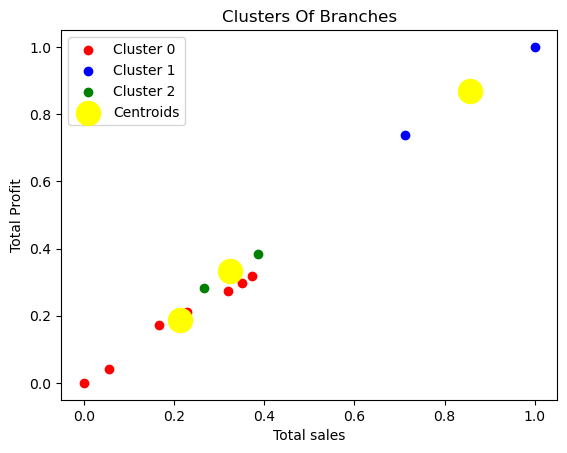

In [28]:
# Visualizing the clusters 
X = np.array(percent)
plt.scatter(X[y_kmeans == 0,0], X[y_kmeans == 0, 1], c = 'red', label = 'Cluster 0')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], c = 'blue', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], c = 'green', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters Of Branches') 
plt.xlabel("Total sales")
plt.ylabel("Total Profit")
plt.legend()
plt.show()

In [29]:
# put the results in a column
percent['التصنيف الشهري'] = y_kmeans

# Replace the values with the appropriate category
percent['التصنيف الشهري'].replace(categorize(kmeans.cluster_centers_[:, 1], 3), inplace = True) 

percent['فريق المبيعات'] = y 
#Replace the standarized values with the real values
percent[['إجمالي المبيعات', 'إجمالي الربح','إجمالي الخصومات الاضافية', 'عدد المنتجات المختلفة المباعة']] =  branches_all[['إجمالي المبيعات', 'إجمالي الربح','إجمالي الخصومات الاضافية', 'عدد المنتجات المختلفة المباعة']]

# ordering the columns
cols_list = ['فريق المبيعات', 'إجمالي المبيعات', 'إجمالي الربح', 'إجمالي الخصومات الاضافية', 'عدد المنتجات المختلفة المباعة']
percent[cols_list] = branches_all[cols_list].copy() 

#set the branches as an index
percent.set_index('فريق المبيعات', inplace = True)

# Save the report
percent.sort_values(by = 'النسبة', ascending = False).to_excel('تصنيف الفروع.xlsx')

## Product Reports

### Drop additional discounts, services, and deposits from dataframe in order to get accurate results

In [30]:
# perparing our new dataframe that we will work on 
df2 = df.copy()

# In the Products report, we don't want any additional discounts, deposits, and services to appear. So, we will drop them
df2.drop(df_addition_discount.index, inplace = True)
df2.drop(df_services.index, errors= 'ignore', inplace = True)
df2.drop(df_deposit.index, errors= 'ignore', inplace = True)

In [31]:
# getting the returned orders and put it in a special dataframe
return_order = df2[df2['Quantity'] < 0]

# making a pivot to know the value of returned orders side by side with the quantity returned from each product 
most_return=pd.pivot_table(return_order, index = ['Barcode', 'Product'], values= ['Quantity', 'Subtotal'], aggfunc = 'sum').sort_values(by = ['Quantity'])
most_return.reset_index(inplace = True)

# changing the names of the columns 
most_return.rename(columns = {'Product': 'المنتج', 'Barcode': 'باركود',
                    'Quantity': 'عدد الوحدات المسترجعة', 
                     'Subtotal': 'إجمالي المبيعات'}, inplace = True)

# making the barcode is the index of the returned orders  
most_return.set_index('باركود' ,inplace = True)

# sorting the returned products data frame by the quantity returned and the subtotal of each product
most_return = most_return.sort_values(by = ['عدد الوحدات المسترجعة', 'إجمالي المبيعات'])

# Saving the returned products data frame
most_return.to_excel('متراجعات.xlsx')

### Most Sold Worksheet

In [32]:
# Getting the most sold products 
df_Product_sold_units = pd.pivot_table(df2,index=['Product'], values=(['Quantity']), aggfunc = 'sum')
df_Product_sold_units.rename(columns ={'Quantity':'Sold units'}, inplace = True)

# Getting the barcode of the products
df_Product_sold_units = df_Product_sold_units.merge(df[['Barcode', 'Product']].drop_duplicates(), how = 'inner', on = 'Product')

#### Total Sales Worksheet

In [33]:
# Getting the products according to the revenues we got from selling it
df_Product_sales = pd.pivot_table(df2,index=['Product'], values=(['Subtotal']), aggfunc = 'sum')

# Change the names of our columns
df_Product_sales.rename(columns ={'Subtotal':'Total Sales'}, inplace = True)

#### Merging the most sold with the total sales 

In [34]:
# adding the number of our sold units to our total sales column
df_Product_sold= df_Product_sold_units.merge(df_Product_sales, how = 'inner', on = 'Product').sort_values(by = ['Sold units'])

# reordering the columns for a better appearance 
df_Product_sold = df_Product_sold[['Product', 'Barcode', 'Sold units', 'Total Sales']]

In [35]:
product_units_sales = df_Product_sold.copy()
product_units_sales.rename(columns = {'Product': 'المنتج', 'Barcode': 'باركود',
                    'Sold units': 'عدد الوحدات المرتجعة', 'Total Sales': 'إجمالي المبيعات'}, inplace = True)

#### Save Top product according to its Sales

In [36]:
product_units_sales = df_Product_sold
product_units_sales.rename(columns = {'Product': 'المنتج', 'Barcode': 'باركود',
                    'Sold units': 'عدد الوحدات', 'Total Sales': 'إجمالي المبيعات'}, inplace = True)

product_units_sales.set_index('باركود', inplace = True)
product_units_sales.sort_values(by= 'إجمالي المبيعات', ascending = False).head(10).to_excel('Products report.xlsx',
                                                                                            sheet_name= 'اكثر المنتجات من حيث القيمة')

#### Save Top product according to its sold units

In [37]:
with pd.ExcelWriter('Products report.xlsx', engine='openpyxl', mode='a') as writer:
    product_units_sales.sort_values(by= 'عدد الوحدات', ascending = False).head(10).to_excel(writer, sheet_name= 'اكثر المنتجات مبيعا')

#### Save most returned products 

In [38]:
# save Returned products 
with pd.ExcelWriter('Products report.xlsx', engine='openpyxl', mode='a') as writer:
    most_return.head(5).to_excel(writer, sheet_name= 'اكثر المنتجات ارجاعا')

#### Save least product sales according to its sold units

In [39]:
least_products = product_units_sales[product_units_sales['عدد الوحدات'] > 0]
with pd.ExcelWriter('Products report.xlsx', engine='openpyxl', mode='a') as writer:
    least_products.sort_values(by= ['عدد الوحدات', 'إجمالي المبيعات']).head(10).to_excel(writer, sheet_name= 'اقل المنتجات مبيعا')

#### Save least product according to its Sales

In [40]:
with pd.ExcelWriter('Products report.xlsx', engine='openpyxl', mode='a') as writer:
    least_products[least_products['إجمالي المبيعات'] > 0].sort_values(by= ['إجمالي المبيعات']).head(5).to_excel(writer, sheet_name= 'اقل المنتجات مبيعا من حيث القيمة')

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


#### Top products accroding to its profit

In [41]:
df_Product_profit = pd.pivot_table(df2,index=['Product'], values=(['profit margin']), aggfunc = 'sum')
df_Product_profit.rename(columns ={'profit margin':'Total profit'}, inplace = True)

# adding the sold units columns in the dataframe of the profit
df_Product_profit = df_Product_sold_units.merge(df_Product_profit, how = 'inner', on = 'Product').sort_values(by = ['Sold units'])
df_Product_profit.rename(columns = {'Product': 'المنتج', 'Barcode': 'باركود',
                    'Sold units': 'عدد الوحدات المرتجعة', 'Total profit': 'إجمالي الربح'}, inplace = True)

# Setting the product and its barcode as an index to our dataframe
df_Product_profit.set_index(['باركود', 'المنتج'], inplace = True)

#saving the top profit products as a worksheet in the excel file "products reports"  
with pd.ExcelWriter('Products report.xlsx', engine='openpyxl', mode='a') as writer:
    df_Product_profit.sort_values(by= 'إجمالي الربح', ascending = False).head(10).to_excel(writer, sheet_name= 'اكثر المنتجات ربحا')

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Service Report

#### Aggregate products based on sold units

In [42]:
df_services_sold_units = pd.pivot_table(df_services,index=['Product'], values=(['Quantity']), aggfunc = 'sum')
df_services_sold_units.rename(columns ={'Quantity':'Sold units'}, inplace = True)

#add the barcodes to the products in our dataframe
df_services_sold_units = df_services_sold_units.merge(df[['Barcode', 'Product']].drop_duplicates(), how = 'inner', on = 'Product')

#### Aggregate services based on our sold units


In [43]:
df_services_sales = pd.pivot_table(df_services,index=['Product'], values=(['Subtotal']), aggfunc = 'sum')
df_services_sales.rename(columns ={'Subtotal':'Total Sales'}, inplace = True)

#### Save all products ordered by its sales 

In [44]:
# adding the sold units column to the total sales column
df_service_sold= df_services_sold_units.merge(df_services_sales, how = 'inner', on = 'Product').sort_values(by = ['Sold units'])

#For better appearance
df_service_sold = df_service_sold[['Product', 'Barcode', 'Sold units', 'Total Sales']]

# renaming our columns
df_service_sold.rename(columns = {'Product': 'الخدمة', 'Barcode': 'باركود',
                    'Sold units': 'عدد مرات طلب الخدمة', 'Total Sales': 'إجمالي المبيعات'}, inplace = True)

# setting the service as an index
df_service_sold.set_index('الخدمة', inplace = True)

# saving our report
with pd.ExcelWriter('Products report.xlsx', engine='openpyxl', mode='a') as writer:
    df_service_sold.sort_values(by= 'إجمالي المبيعات', ascending = False).to_excel(writer, sheet_name= 'ااكثر الخدمات طلبا')

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Employees Reports

#### Perpare the dataFrame we will work with 

In [45]:
# Setting the quantity column for all additional discounts to zero
df_addition_discount.loc[ : ,'Quantity'] = 0
df3 =df.copy()
df3.loc[list(df_addition_discount.index) ,'Quantity'] = 0

# Removve the deposits and services from the dataframe
df3.drop(df_services.index, errors= 'ignore', inplace = True)
df3.drop(df_deposit.index, errors= 'ignore', inplace = True)

#### Remove the Websites sales

In [46]:
xx = df3[df3['Branch'] == 'مبيعات نقاط بيع متجر راحتي الالكتروني']
df3.drop(xx.index, axis = 0, inplace = True)
xx = df3[df3['Branch'] == 'المتجر الإلكتروني']
df3.drop(xx.index, axis = 0, inplace = True)


In [47]:
xx = df3[df3['فريق المبيعات'] == 'قصر البيان الإلكتروني']
df3.drop(xx.index, axis = 0, inplace = True)
xx = df3[df3['فريق المبيعات'] == 'الموقع تبوك']
df3.drop(xx.index, axis = 0, inplace = True)

#### Remove Branch Whatsup accounts from employees

In [48]:
df3.drop(df3[df3['Order Ref/Cashier'].isna()].index, inplace = True)
whatsup = df3[df3['Order Ref/Cashier'].str.contains('واتس')]
df3.drop(whatsup.index, inplace = True)
cashier = df3[df3['Order Ref/Cashier'].str.contains('كاشير')]
df3.drop(cashier.index, inplace = True)


##### Employees Sold unit

In [49]:
Employee_sold_units = pd.pivot_table(df3,index=['Order Ref/Cashier'], values=(['Quantity']), aggfunc = 'sum')
Employee_sold_units.rename(columns ={'Quantity':'Sold units'}, inplace = True)
df_Employee_sold_units= Employee_sold_units.merge(df3[['فريق المبيعات',
                                                'Order Ref/Cashier']].drop_duplicates(), on ='Order Ref/Cashier', how= 'inner')

##### solve the problem of the movement of salesmen from one branch to another at the same week

In [50]:
# Aggregating all branches each employee worked for
emp_duplicates_df = pd.DataFrame(df_Employee_sold_units.groupby('Order Ref/Cashier')['فريق المبيعات'].apply(lambda x: list(x)))
emp_duplicates_df.reset_index(inplace = True)

# Mereging the emp_duplicates dataframe with the Employee_sold_units dataframe 
emp_duplicates_df = emp_duplicates_df.merge(Employee_sold_units, on ='Order Ref/Cashier', how= 'inner')
emp_duplicates_df = emp_duplicates_df[['Order Ref/Cashier', 'Sold units', 'فريق المبيعات']]

In [51]:
list_employee_cor = []
employee_dup_index = []
employee_dup_indexes = list(df_Employee_sold_units[df_Employee_sold_units['Order Ref/Cashier'].duplicated()].index)
employee_dup_names = df_Employee_sold_units.loc[employee_dup_indexes, 'Order Ref/Cashier']

# Getting the employees that worked in more than branc from emp_duplicates dataframe
for e in employee_dup_names:
    list_employee_cor.append(emp_duplicates_df[emp_duplicates_df['Order Ref/Cashier'] == e].index[0])

# Getting the employees that worked in more than branch from df_Employee_sold_units dataframe    
for u in range(0, len(employee_dup_indexes)):
    employee_dup_index.append(employee_dup_indexes[u])    

# corecting the duplicates in the df_Employee_sold_units dataframe
for i in range(0 , len(list_employee_cor)):
    o = list_employee_cor[i]
    p = employee_dup_index[i]
    df_Employee_sold_units.loc[p, 'فريق المبيعات'] = str(emp_duplicates_df.loc[o, 'فريق المبيعات'])

# Dropping the duplicates so that our data frame becomes ready for our analysis
df_Employee_sold_units.drop_duplicates(subset = ['Order Ref/Cashier'], keep = 'last', inplace = True)

## Employees Sales Report

In [52]:
# aggregating the sales for each employee
df_Employee_sales= pd.pivot_table(df,index=['Order Ref/Cashier'],values=(['Subtotal']), aggfunc = 'sum')
df_Employee_sales.rename(columns ={'Subtotal':'total sales'}, inplace = True)

# add the sold units column for each employee and remove the duplicates by 'inner'
df_Employee_sales = df_Employee_sales.merge(df_Employee_sold_units, on= 'Order Ref/Cashier', how = 'inner')

# Ordering the columns of our dataframe for better appearance
df_Employee_sales = df_Employee_sales[['Order Ref/Cashier', 'فريق المبيعات', 'Sold units', 'total sales']]
df_Employee_sales.sort_values(by= 'total sales', ascending = False).head(10)
df_Employee_sales.rename(columns = {"Order Ref/Cashier": 'موظف المبيعات',
                          'Sold units': 'عدد الوحدات المباعة', 
                          'total sales': 'اجمالي المبيعات'}, inplace = True)

#### Save top seller employees according to sold units

In [53]:
# aggregating the sold units for each employee
Most_sold= pd.pivot_table(df3,index=['Order Ref/Cashier'], values=(['Subtotal']), aggfunc = 'sum')
Most_sold.rename(columns ={'Subtotal':'total sales'}, inplace = True)

# remove the duplicates 
Most_sold = Most_sold.merge(df_Employee_sold_units, on= 'Order Ref/Cashier', how = 'inner')

# Ordering the columns of our dataframe for better appearance
Most_sold = Most_sold[['Order Ref/Cashier', 'فريق المبيعات', 'Sold units', 'total sales']]
Most_sold.sort_values(by= 'total sales', ascending = False).head(10)

# Renaming the columns for better readability
Most_sold.rename(columns = {"Order Ref/Cashier": 'موظف المبيعات',
                          'Sold units': 'عدد الوحدات المباعة', 
                          'total sales': 'اجمالي المبيعات'}, inplace = True)

# Set the employees column as an index
Most_sold.set_index('موظف المبيعات', inplace = True)

# sace the top 10 seller employees accroding to their sold units
Most_sold.sort_values(by= 'عدد الوحدات المباعة', ascending = False).head(10).to_excel('Employees report.xlsx',
                                                                                    sheet_name='اكثر الموظفين بيعا')

#### Save least seller employees

In [54]:
# aggregating the returned products for each employee
most_return= pd.pivot_table(df3[df3['Quantity'] < 0],index=['Order Ref/Cashier'], values=['Subtotal', 'Quantity'], aggfunc = 'sum')
most_return = most_return.merge(df_Employee_sold_units[['Order Ref/Cashier', 'فريق المبيعات']], on= 'Order Ref/Cashier', how = 'inner')

# Rename the columns for better readability
most_return.rename(columns = {'Quantity': 'عدد الوحدات المسترجعة',                              
                              'Subtotal': 'اجمالي المبلغ',
                   'Order Ref/Cashier': 'موظف المبيعات',
                   'Sold units': 'عدد الوحدات المسترجعة'}, inplace = True)


# Set the employees column as an index
most_return.set_index('موظف المبيعات', inplace = True)

# sace the top 10 seller employees accroding to their returned products
with pd.ExcelWriter('Employees report.xlsx', engine='openpyxl', mode='a') as writer:
    most_return.sort_values(by= ['عدد الوحدات المسترجعة', 'اجمالي المبلغ'], ascending = True).head(10).to_excel(writer, sheet_name= 'اكثر الموظفين ارجاعا')

#### Save top seller employees according to amount of money Gained 

In [55]:
# sace the top 10 seller employees accroding to their sales
with pd.ExcelWriter('Employees report.xlsx', engine='openpyxl', mode='a') as writer:
    df_Employee_sales.set_index('موظف المبيعات', inplace = True)
    df_Employee_sales.sort_values(by= 'اجمالي المبيعات', ascending = False).head(10).to_excel(writer, sheet_name= 'اكثر الموظفين مبيعا من حيث القيمة')
    

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


#### Save least seller employees according to amount of money Gained 

In [56]:
# getting all the employees that sold more than one order
least_seller= df_Employee_sales[df_Employee_sales['اجمالي المبيعات'] > 0]
least_seller.reset_index(inplace = True)

# Removing the whatsup value from the dataframe
whatsup= list(least_seller[least_seller['موظف المبيعات'].str.contains('واتس')].index)
least_seller.drop(whatsup, inplace = True)

# Set the employees column as an index
least_seller.set_index('موظف المبيعات', inplace = True)

# sace the least 10 employees accroding to their sales
with pd.ExcelWriter('Employees report.xlsx', engine='openpyxl', mode='a') as writer:
    least_seller.sort_values(by='اجمالي المبيعات').head(10).to_excel(writer, sheet_name= 'اقل الموظفين مبيعا من حيث القيمة')
    

C:\Users\Rahaty Store\AppData\Local\Temp\ipykernel_14608\970185673.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  least_seller.drop(whatsup, inplace = True)
C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


### Best Employee In Each Branch

In [57]:
#parpare the table of the whole employees allowing duplication for the salesmen who sell in two places
Best_employees = pd.pivot_table(df3,index=['فريق المبيعات','Order Ref/Cashier'], values=['Quantity'], aggfunc = 'sum')
Best_employees.reset_index(inplace = True)

# aggregating the sales for each employee
Best_employees_total = pd.pivot_table(df,index=['فريق المبيعات','Order Ref/Cashier'], values=['Subtotal'], aggfunc = 'sum')
Best_employees_total.reset_index(inplace = True)

#adding the sold units column
Best_employees = Best_employees.merge(Best_employees_total, on =['فريق المبيعات','Order Ref/Cashier'], how = 'inner')

# Renaming the columns for better readability
Best_employees.rename(columns = {'Quantity': 'عدد الوحدات',
                   'Subtotal': 'اجمالي المبيعات',
                   'Order Ref/Cashier': 'الموظف'}, inplace = True)

# perparing the data dataframe that will store the best employee in eaach branch
df_best_per_branch = pd.DataFrame()

#getting the list of branches we have
listbranches = list(Best_employees['فريق المبيعات'].unique())


# getting the top seller in each branch 
for b in listbranches:
    df_best_per_branch = pd.concat([df_best_per_branch, Best_employees[Best_employees['فريق المبيعات'] == b].set_index('الموظف').sort_values(by = 'اجمالي المبيعات', ascending = False).head(1)])

#### Save the top seller employee in each branch 

In [58]:
with pd.ExcelWriter('Employees report.xlsx', engine='openpyxl', mode='a') as writer:
    df_best_per_branch.to_excel(writer, sheet_name= 'افضل بائع في كل فرع')

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


### Ordering the employees acccording to their branches and their sales amount of money

In [59]:
#getting the list of branches we have
Branches = list(df3['فريق المبيعات'].unique())

# perparing the data dataframe that will store the best employee in eaach branch
df_branch_emp = pd.DataFrame()

# put the best employees in the df_branch_emp dataframe
for b in listbranches:
    df_branch_emp = pd.concat([df_branch_emp, Best_employees[Best_employees['فريق المبيعات'] == b].sort_values(by = 'اجمالي المبيعات', ascending = False)])

# aggregating the sales for each employee
total_branch_sales = pd.DataFrame(pd.pivot_table(df, index=['فريق المبيعات'], values=(['Subtotal']), aggfunc = 'sum'))
df_best_per_branch = df_branch_emp.merge(total_branch_sales, how ='inner', on = 'فريق المبيعات')

# calculating the percent of sales column
df_best_per_branch['نسبة البيع من اجمالي المبيعات'] = df_best_per_branch['اجمالي المبيعات'] / df_best_per_branch['Subtotal'] 
df_best_per_branch.drop(columns = 'Subtotal', inplace = True )
df_best_per_branch.to_excel('Employees per Branch.xlsx')

#storing each branch employees in a worksheet in the excel file
for b in Branches:
    data = df_best_per_branch[df_best_per_branch['فريق المبيعات'] == b]
    data.set_index('الموظف', inplace = True)
    with pd.ExcelWriter('Employees per Branch.xlsx', engine='openpyxl', mode='a') as writer:
        data.sort_values(by= 'اجمالي المبيعات', ascending = False).head(10).to_excel(writer, sheet_name= b) 

## Employees Profit Report

In [60]:
# aggregating the porfit for each employee
df_Employee_profit= pd.pivot_table(df,index=['Order Ref/Cashier'], values=(['profit margin']), aggfunc = 'sum')
df_Employee_profit.rename(columns ={'profit margin':'total profit'}, inplace = True)

#adding the sold units column
df_Employee_profit = df_Employee_profit.merge(df_Employee_sold_units, on= 'Order Ref/Cashier', how = 'inner')

# Ordering the columns of our dataframe for better appearance
df_Employee_profit = df_Employee_profit[['Order Ref/Cashier', 'فريق المبيعات', 'Sold units', 'total profit']]

# Set the profit column as an index
df_Employee_profit.sort_values(by= 'total profit', ascending = False)

# Renaming the columns for better readability
df_Employee_profit.rename(columns = {"Order Ref/Cashier": 'موظف المبيعات',
                          'Sold units': 'عدد الوحدات المباعة', 
                          'total profit': 'اجمالي الربح'}, inplace = True)

#### Save top total sales


In [61]:
with pd.ExcelWriter('Employees report.xlsx', engine='openpyxl', mode='a') as writer:
    df_Employee_profit.set_index('موظف المبيعات', inplace = True)
    df_Employee_profit.sort_values(by= 'اجمالي الربح', ascending = False).head(10).to_excel(writer, sheet_name= 'اكثر الموظفين من حيث الربح')

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Employees Clustering Report

### Calculating the variety measure 

In [62]:
# Calculating the number of categories each employee sold at least one product from
var =  pd.DataFrame(df3.groupby(['Order Ref/Cashier', 'Cat1'])['Cat1'].nunique())
var.rename(columns = {'Cat1': 'عدد الوحدات المباعة'}, inplace = True)
var.reset_index(inplace = True)
values_list = []
employees_nameslist= list(var['Order Ref/Cashier'].unique())

# Calculating the variety for each employee and put it in the values_list
for n in employees_nameslist:
    df_temp = var[var['Order Ref/Cashier'] == n]
    val = (1- (df_temp['عدد الوحدات المباعة'].max() /  df_temp['عدد الوحدات المباعة'].sum()))
    values_list.append(val)

In [63]:
# take a copy of the var dataframe and delete the number of sold units
variety = var.copy()
variety.drop(columns = {'Cat1', 'عدد الوحدات المباعة'}, inplace = True)
variety.drop_duplicates(inplace = True)

# put the variety measure in the variety dataframe
variety['مقياس التنوع'] = values_list

# Renaming the columns for better readability
variety.rename(columns = {'Order Ref/Cashier': 'موظف المبيعات'}, inplace = True)

### Calculating all the factors, we will assess the salesmen based on

In [64]:
work_days= pd.pivot_table(df3,
                          index = ['Order Ref/Cashier'],
                          values = ['day'],
                          aggfunc = 'nunique')
work_days.reset_index(inplace = True)
work_days.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                               'day': 'عدد ايام العمل'}, inplace = True)

profit= pd.pivot_table(df3,
                       index = ['Order Ref/Cashier'],
                       values = ['profit margin'],
                       aggfunc = 'sum')
profit.reset_index(inplace = True)
profit.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                               'profit margin': 'الربح'}, inplace = True)


mean_profit= pd.pivot_table(df3,
                       index = ['Order Ref/Cashier'],
                       values = ['profit margin'],
                       aggfunc = 'mean')
mean_profit.reset_index(inplace = True)
mean_profit.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                              'profit margin': 'متوسط الربح اليومي'}, inplace = True)



total_discounts= pd.pivot_table(df3,
                       index = ['Order Ref/Cashier'],
                       values = ['Total discount'],
                       aggfunc = 'sum')
total_discounts.reset_index(inplace = True)
total_discounts.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                              'Total discount': 'إجمالي الخصم'}, inplace = True)



variety_products= pd.pivot_table(df3,
                       index = ['Order Ref/Cashier'],
                       values = ['Product'],
                       aggfunc = 'nunique')
variety_products.reset_index(inplace = True)
variety_products.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                              'Product': 'عدد الاصناف المباعة'}, inplace = True)


variety_cat= pd.pivot_table(df3,
                       index = ['Order Ref/Cashier'],
                       values = ['cat3'],
                       aggfunc = 'nunique')
variety_cat.reset_index(inplace = True)
variety_cat.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                              'cat3': 'عدد الفئات المباعة'}, inplace = True)



total_cost= pd.pivot_table(df3,
                       index = ['Order Ref/Cashier'],
                       values = ['Cost'],
                       aggfunc = 'sum')
total_cost.reset_index(inplace = True)
total_cost.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                              'Cost': 'إجمالي تكلفة المنتجات'}, inplace = True)


df_addition_discount.loc[:, 'Quantity'] = 1
employees_discounts = pd.pivot_table(df_addition_discount,
                                     index = ['Order Ref/Cashier', 'فريق المبيعات'],
                                     values = ['Quantity','Subtotal'], aggfunc = 'sum')

employees_discounts.reset_index(inplace = True)
employees_discounts.rename(columns = {'Order Ref/Cashier':'موظف المبيعات',
                               'Quantity': 'عدد مرات استخدام الخصم الاضافي',
                               'Subtotal': 'إجمالي الخصومات الاضافية'}, inplace = True)


In [65]:
# merge all the factors in one dataFrame called all_employees
all_employees = df_Employee_sales.merge(work_days, on = 'موظف المبيعات', how = 'inner')
all_employees = all_employees.merge(profit, on = ['موظف المبيعات'], how = 'left')
all_employees = all_employees.merge(mean_profit, on = ['موظف المبيعات'], how = 'left')
all_employees = all_employees.merge(total_discounts, on = ['موظف المبيعات'], how = 'left')
all_employees = all_employees.merge(variety_products, on = ['موظف المبيعات'], how = 'left')
all_employees = all_employees.merge(variety_cat, on = ['موظف المبيعات'], how = 'left')
all_employees = all_employees.merge(total_cost, on = ['موظف المبيعات'], how = 'left')
all_employees = all_employees.merge(employees_discounts, on = ['موظف المبيعات', 'فريق المبيعات'], how = 'left')
all_employees = all_employees.merge(variety, on = 'موظف المبيعات', how = 'inner')

In [66]:
# Solve the problem of returned discounts
for r in list(all_employees.index):
    if all_employees.loc[ r ,'إجمالي الخصومات الاضافية'] == 0:
        all_employees.loc[ r ,'عدد مرات استخدام الخصم الاضافي'] = 0
        
all_employees.fillna(0, inplace = True)

In [67]:
# Calculating extra factors
all_employees['إجمالي الخصم'] = all_employees['إجمالي الخصم'] * -1
all_employees['إجمالي الخصومات بالخصم الاضافي'] = all_employees['إجمالي الخصومات الاضافية'] + all_employees['إجمالي الخصم'] 
all_employees['معدل الخصم'] = all_employees['إجمالي الخصومات بالخصم الاضافي'] / all_employees['اجمالي المبيعات']
all_employees['معدل الربح'] = (all_employees['اجمالي المبيعات'] - all_employees['إجمالي تكلفة المنتجات']) / all_employees['اجمالي المبيعات']
all_employees['متوسط ميبعات اليوم'] = all_employees['اجمالي المبيعات'] / all_employees['عدد ايام العمل']
all_employees['متوسط الوحدات المباعة في اليوم'] = all_employees['عدد الوحدات المباعة'] / all_employees['عدد ايام العمل']
all_employees['متوسط عدد الفئات المباعة في اليوم'] = all_employees['عدد الفئات المباعة'] / all_employees['عدد ايام العمل']
all_employees['متوسط الاصناف المباعة في اليوم'] = all_employees['عدد الاصناف المباعة'] / all_employees['عدد ايام العمل']

In [68]:
# Solve the problem of returned orders
for r in list(all_employees.index):
    if all_employees.loc[ r, 'اجمالي المبيعات']   == 0:
        all_employees.loc[ r , 'معدل الخصم'] =0
        all_employees.loc[ r , 'معدل الربح'] = 0

## Potential Assessment 

In [69]:
# put all the factors, we will assess the potentail based on
assess = all_employees[['متوسط ميبعات اليوم',
                         'متوسط الوحدات المباعة في اليوم',
                         'معدل الخصم',
                         'معدل الربح',
                         'متوسط عدد الفئات المباعة في اليوم',
                         'متوسط الاصناف المباعة في اليوم']]

In [70]:
# getting a standarized copy of the assess_rate dataframe
assess_rate = assess.copy()
for f in list(assess_rate.columns):
    try:
        Max_Min_Standardization(f,assess_rate)
    except:
        continue

name1 = '(نسبة)التمييز الوظيفي'
name2 = Degree_From(assess_rate, name1)

In [71]:
# putting the unuse factors in the y dataframe
y = assess_rate[[name1, name2]]
assess_rate.drop(columns = {name1, name2}, inplace = True)

### Running the Clustering Algorithm

In [72]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(assess_rate)

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Rahaty Store\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualizing The Results

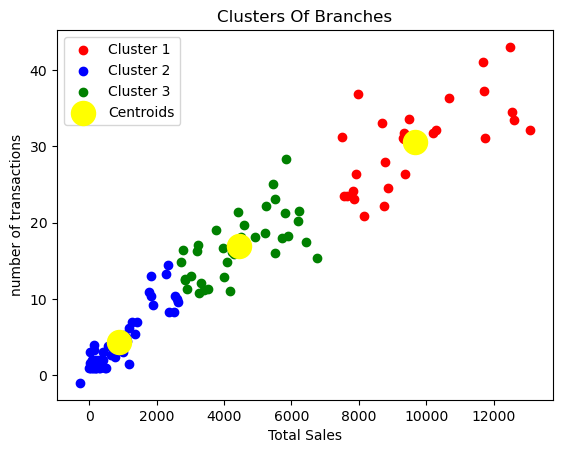

In [73]:
X = np.array(assess_rate)
plt.scatter(X[y_kmeans == 0,0], X[y_kmeans == 0, 1], c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters Of Branches')
plt.xlabel('Total Sales')
plt.ylabel('number of transactions')
plt.legend()
plt.show()

In [74]:
# Putting and replacing the values of the clustering algorithm with our categorize values in the assess_rate dataframe
assess_rate['التصنيف الشهري للتميز'] = y_kmeans
assess_rate['التصنيف الشهري للتميز'].replace(categorize(kmeans.cluster_centers_[:, 1], 3), inplace = True) 
assess_rate[list(y.columns)] = y

# replacing the standardized values with original values
all_employees['التصنيف الشهري للتميز'] = assess_rate['التصنيف الشهري للتميز']

In [75]:
#Copy the columns names from assess dataframe to assess_rate dataframe 
assess_rate[assess.columns] = assess[assess.columns]

# remove the duplication of the employees
assess_rate[['فريق المبيعات', 'موظف المبيعات']] = all_employees[['فريق المبيعات', 'موظف المبيعات']]

# putting the '(نسبة)التمييز الوظيفي' in all_employees dataframe
all_employees[['(نسبة)التمييز الوظيفي']] = assess_rate[['(نسبة)التمييز الوظيفي']]

# Ordering the columns of the assess_rate dataframe
assess_rate = assess_rate[['موظف المبيعات',
                         'فريق المبيعات',
                         'متوسط ميبعات اليوم',
                         'متوسط الوحدات المباعة في اليوم',
                         'معدل الخصم',
                         'معدل الربح',
                         'متوسط عدد الفئات المباعة في اليوم',
                         'متوسط الاصناف المباعة في اليوم',
                         'الدرجة من 6',
                         '(نسبة)التمييز الوظيفي',
                         'التصنيف الشهري للتميز']]

# ordering the dataset
assess_rate = assess_rate.sort_values(by =['التصنيف الشهري للتميز'])

## Performance Assessment 

In [76]:
Performance = all_employees[['عدد الوحدات المباعة'
                , 'اجمالي المبيعات'
                ,'الربح'
                ,'إجمالي الخصومات الاضافية'
                ,'إجمالي الخصومات بالخصم الاضافي'
                ,'عدد الاصناف المباعة'
                ,'عدد الفئات المباعة']]

In [77]:
# getting a standarized copy of the assess_rate dataframe
Performance_assess = Performance.copy()
for x in list(Performance_assess.columns):
    try:
        Max_Min_Standardization(x,Performance_assess)
    except:
        continue

name1 = '(نسبة)الاداء الوظيفي'
name2 = Degree_From(Performance_assess, name1)

In [78]:
y = Performance_assess[[name1, name2]] 
y[['موظف المبيعات', 'فريق المبيعات']] = all_employees[['موظف المبيعات', 'فريق المبيعات']]
Performance_assess.drop(columns = {name1, name2}, inplace = True)

C:\Users\Rahaty Store\AppData\Local\Temp\ipykernel_14608\992025686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[['موظف المبيعات', 'فريق المبيعات']] = all_employees[['موظف المبيعات', 'فريق المبيعات']]
C:\Users\Rahaty Store\AppData\Local\Temp\ipykernel_14608\992025686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[['موظف المبيعات', 'فريق المبيعات']] = all_employees[['موظف المبيعات', 'فريق المبيعات']]


### Running the Clustering Algorithm

In [79]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(Performance_assess)

C:\Users\Rahaty Store\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Rahaty Store\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualizing The Results

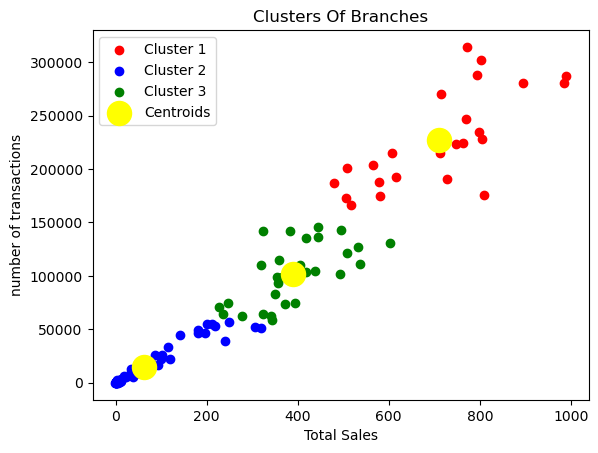

In [80]:
X = np.array(Performance_assess)
plt.scatter(X[y_kmeans == 0,0], X[y_kmeans == 0, 1], c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters Of Branches')
plt.xlabel('Total Sales')
plt.ylabel('number of transactions')
plt.legend()
plt.show()

In [81]:
# Putting and replacing the values of the clustering algorithm with our categorize values in the assess_rate dataframe
Performance_assess['التصنيف الشهري للاداء'] = y_kmeans
Performance_assess['التصنيف الشهري للاداء'].replace(categorize(kmeans.cluster_centers_[:, 1], 3), inplace = True) 
Performance_assess[y.columns] = y

# replacing the standardized values with original values
all_employees[['التصنيف الشهري للاداء', '(نسبة)الاداء الوظيفي']] = Performance_assess[['التصنيف الشهري للاداء', '(نسبة)الاداء الوظيفي']]

In [82]:
# ordering the dataframe for a better appearance
Performance_assess = Performance_assess[['موظف المبيعات',
                                    'فريق المبيعات',
                                   'عدد الوحدات المباعة',
                                    'اجمالي المبيعات',
                                    'الربح',
                                    'إجمالي الخصومات الاضافية',
                                    'إجمالي الخصومات بالخصم الاضافي',
                                    'عدد الاصناف المباعة',
                                    'عدد الفئات المباعة',
                                    'التصنيف الشهري للاداء',
                                    '(نسبة)الاداء الوظيفي',
                                    'الدرجة من 7']]

In [83]:
# putting some columns from all_employees to Performance_assess
columns = ['عدد الوحدات المباعة'
                , 'اجمالي المبيعات'
                ,'الربح'
                ,'إجمالي الخصومات الاضافية'
                ,'إجمالي الخصومات بالخصم الاضافي'
                ,'عدد الاصناف المباعة'
                ,'عدد الفئات المباعة']

Performance_assess[columns] = all_employees[columns]

In [84]:
# ordering the values of Performance_assess dataframe
Performance_assess = Performance_assess.sort_values(by = '(نسبة)الاداء الوظيفي', ascending =  False)

# merging all the information from the Performance_assess and assess_rate datasets to a new dataset called clustering_agg 
clustering_agg = Performance_assess.merge(assess_rate, on = ['موظف المبيعات', 'فريق المبيعات'], how = 'inner')
clustering_agg = clustering_agg[[ 'موظف المبيعات',
                                 'فريق المبيعات', 
                                 'التصنيف الشهري للتميز',
                                 '(نسبة)التمييز الوظيفي',
                                 'التصنيف الشهري للاداء',
                                '(نسبة)الاداء الوظيفي']]
clustering_agg['التقيم النهائي'] = (clustering_agg['(نسبة)التمييز الوظيفي'] + clustering_agg['(نسبة)الاداء الوظيفي'])/2
clustering_agg = clustering_agg.sort_values(by = ['التقيم النهائي'], ascending = False)

In [85]:
# setting the employee column as an index for our four dataframes
Performance_assess.set_index('موظف المبيعات', inplace = True)
assess_rate.set_index('موظف المبيعات', inplace = True)
all_employees.set_index('موظف المبيعات', inplace = True)
clustering_agg.set_index('موظف المبيعات', inplace = True)

In [86]:
# ordering the values of all_employees dataframe
all_employees = all_employees.sort_values(by = ['(نسبة)الاداء الوظيفي',
                                '(نسبة)التمييز الوظيفي'], ascending = False)

#### Save all our datasets

In [87]:
assess_rate.to_excel('clustering employees.xlsx', sheet_name = '(التميز) عوامل التقييم')

with pd.ExcelWriter('clustering employees.xlsx', engine='openpyxl', mode='a') as writer:
    Performance_assess.to_excel(writer, sheet_name= 'عوامل التقييم (الاداء)') 
    
with pd.ExcelWriter('clustering employees.xlsx', engine='openpyxl', mode='a') as writer:
    clustering_agg.to_excel(writer, sheet_name= 'التقييم مجمع')
    
with pd.ExcelWriter('clustering employees.xlsx', engine='openpyxl', mode='a') as writer:
    all_employees.to_excel(writer, sheet_name= 'بيانات تفصلية عن الموظفين')


## Get the top five products for each branch

#### Cleaning the main data frame from deposits, services, etc

In [88]:
df4 = df.copy()
df4.drop(df_deposit.index, inplace =True, errors = 'ignore')
df4.drop(df_addition_discount.index, inplace = True, errors = 'ignore')
df4.drop(df_services.index, inplace = True, errors = 'ignore')
df4.drop(df_0.index, inplace = True, errors = 'ignore')

### Get the top five products for each branch according to sales 

In [89]:
data_sales = pd.DataFrame()
Branches = list(df4['فريق المبيعات'].unique())
df.to_excel((str(m[0]) + ' products Per Branch' +'.xlsx'), sheet_name = 'Data')
for x in Branches: 
    try:
        branch_team = df3[df3['فريق المبيعات'] == x]
        Total_sold = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Quantity']), aggfunc = 'sum')
        Total_sold.rename(columns ={'Quantity':'sold units'}, inplace = True)
        Total_sold = Total_sold.sort_values(by= 'sold units', ascending = False).head(5)
    except:
        continue
    mean_discounts = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Total discount']), aggfunc = 'mean')
    mean_discounts.rename(columns ={'Total discount':'mean discounts'}, inplace = True)        
    total_sales = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Subtotal']), aggfunc = 'sum')
    total_sales.rename(columns ={'profit margin':'Total sales'}, inplace = True)
    df2 = Total_sold.merge(mean_discounts, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2 = df2.merge(total_sales, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2.sort_values(by= 'sold units', ascending = False)
    
    h = len(df2) + 1
    df2.loc[' ', df2.columns] = ' '
    df2.loc['  ', df2.columns] = ' '
    df2.loc[('فريق المبيعات', 'Product'), df2.columns] = df2.columns
    data_sales  = pd.concat([df2, data_sales], ignore_index=False)


with pd.ExcelWriter((str(m[0]) + ' products Per Branch' +'.xlsx'), engine='openpyxl', mode='a') as writer:
    data_sales.to_excel(writer, sheet_name= 'Sales')   

### Get the top five products for each branch according to sales and profit (individually) 

In [90]:
temp = pd.DataFrame()
Branches = list(df4['فريق المبيعات'].unique())
temp.to_excel((str(m[0]) + ' products Per Branch' +'.xlsx'), sheet_name = 'Data')
for x in Branches: 
    try:
        branch_team = df3[df3['فريق المبيعات'] == x]
        Total_sold = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Quantity']), aggfunc = 'sum')
        Total_sold.rename(columns ={'Quantity':'sold units'}, inplace = True)
        Total_sold = Total_sold.sort_values(by= 'sold units', ascending = False).head(5)
    except:
        continue
    mean_discounts = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Total discount']), aggfunc = 'mean')
    mean_discounts.rename(columns ={'Total discount':'mean discounts'}, inplace = True)        
    total_sales = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Subtotal']), aggfunc = 'sum')
    total_sales.rename(columns ={'profit margin':'Total sales'}, inplace = True)
    total_profit = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['profit margin']), aggfunc = 'sum')
    total_profit.rename(columns ={'profit margin':'Total profit'}, inplace = True)
    
    df2 = Total_sold.merge(mean_discounts, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2 = df2.merge(total_sales, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2 = df2.merge(total_profit, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2.sort_values(by= 'sold units', ascending = False)
    with pd.ExcelWriter((str(m[0]) + ' products Per Branch' +'.xlsx'), engine='openpyxl', mode='a') as writer:
        df2.to_excel(writer, sheet_name= x)   
    



### Get the top five products for each branch according to profit 

In [91]:
data_profit = pd.DataFrame()
for x in Branches: 
    try:
        branch_team = df3[df3['فريق المبيعات'] == x]
        Total_sold = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Quantity']), aggfunc = 'sum')
        Total_sold.rename(columns ={'Quantity':'sold units'}, inplace = True)
        Total_sold = Total_sold.sort_values(by= 'sold units', ascending = False).head(5)
    except:
        continue
    mean_discounts = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['Total discount']), aggfunc = 'mean')
    mean_discounts.rename(columns ={'Total discount':'mean discounts'}, inplace = True)        
    total_profit = pd.pivot_table(branch_team, index=['فريق المبيعات', 'Product'], values=(['profit margin']), aggfunc = 'sum')
    total_profit.rename(columns ={'profit margin':'Total sales'}, inplace = True)
    df2 = Total_sold.merge(mean_discounts, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2 = df2.merge(total_profit, on= ['فريق المبيعات', 'Product'], how= 'inner')
    df2.sort_values(by= 'sold units', ascending = False)
    h = len(df2) + 1
    df2.loc[' ', df2.columns] = ' '
    df2.loc['  ', df2.columns] = ' '
    df2.loc[('فريق المبيعات', 'Product'), df2.columns] = df2.columns
    data_profit  = pd.concat([df2, data_profit], ignore_index=False)

with pd.ExcelWriter((str(m[0]) + ' products Per Branch' +'.xlsx'), engine='openpyxl', mode='a') as writer:
    data_profit.to_excel(writer, sheet_name= 'Profit')  

# Association Analysis

## Without Services

In [92]:
# Aggregating Products Based On The Order ID and put in list of lists called transaction
x = pd.DataFrame(df4.groupby(['Date','رقم الفاتوره'])['Product'].apply(lambda x: list(x)))
transactions = x['Product'].values.tolist()


#### Running the apriori

In [93]:
rules = apriori(transactions, min_support=0.00030,min_confidence = 0.05,min_lift = 2,min_length = 2)
results = list(rules)

#### Cleaning and putting the results in a dataframe

In [94]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
ordered_results = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])
ordered_results.sort_values(by =['Confidence', 'Lift'], ascending = False).head(5)

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
34,[M0472] مرتبة هيبى مون 120*190*18سم M0472,[الشرابية] سرير خشب شرائح 120*190,0.001384,0.755556,185.624889
13,[1161476] طقم طاولات خدمة بني CT CX2213 SET BR,[1161561] طاولة شاي وسط بني CT CX2219 BR,0.000366,0.692308,459.692308
36,[M0655] مرتبة تركى لباد 120*190 - M0655,[الشرابية] سرير خشب شرائح 120*190,0.000326,0.666667,163.786667
15,[BBE-06] سرير أطفال - BBE-06,[M0459] مرتبة هيبي مون 60*120*10سم M0459,0.000733,0.666667,233.980952
29,[FBB-09Y] سرير أطفال - logburly wood-FBB-09Y,[M0459] مرتبة هيبي مون 60*120*10سم M0459,0.000488,0.600000,210.582857


#### Getting how many times each pairs appeared together in the orders

In [95]:
count = [0 for i in range(0, ordered_results.shape[0])]
for i in ordered_results.index:
    for t in transactions:
            if ordered_results.iloc[i, 0] in t:
                if ordered_results.iloc[i, 1] in t:
                    count[i] +=1

                
x =  count[0: ordered_results.shape[0]]
ordered_results['times together algorithm'] = x

#### Putting the results in ordered_results dataset

In [96]:
ordered_results['times in invoice together'] = round(ordered_results['Support'] * len(transactions))
ordered_results['times in invoice together'] = ordered_results['times in invoice together'].astype(int)

#### Save the ordered_results dataset

In [97]:
ordered_results.sort_values(by =['Confidence', 'Lift']).to_excel('Basket_market_analysis.xlsx', sheet_name= 'بدون خدمات', index = False)

## With Products

In [98]:
# Aggregating Products Based On The Order ID and put in list of lists called transaction
x = pd.DataFrame(df.groupby(['Date','رقم الفاتوره'])['Product'].apply(lambda x: list(x)))
transactions = x['Product'].values.tolist()

#### Running the apriori

In [99]:
rules = apriori(transactions, min_support=0.00030,min_confidence = 0.05,min_lift = 2,min_length = 2)
results = list(rules)

#### Cleaning and putting the results in a dataframe

In [100]:
ordered_results = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])
ordered_results.sort_values(by =['Confidence', 'Lift'], ascending = False).head(5)

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
419,قسيمة التخفيض(RA10),الإجمالي النهائي,0.001397,1.000000,11.106466
309,[90309245] خزانة 6 درج ابيض 140x72سم 90309245,الإجمالي النهائي,0.001475,0.950000,10.551142
378,[S01] مرايا ابيض -WHITE -S01,الإجمالي النهائي,0.000582,0.937500,10.412311
6,[00030118] طاولة طعام رخام 8ك M005-1 GREY,[11223344] RS خصم اضافي للعميل,0.000349,0.900000,11.323389
243,[3820] سرير راحتى 90*190 شرائح الوان ابيض 3820,[575730] تركيب مجاني,0.000388,0.833333,6.094947


#### Getting how many times each pairs appeared together in the orders

In [101]:
count = [0 for i in range(0, ordered_results.shape[0])]
for i in ordered_results.index:
    for t in transactions:
            if ordered_results.iloc[i, 0] in t:
                if ordered_results.iloc[i, 1] in t:
                    count[i] +=1

                
x =  count[0: ordered_results.shape[0]]
ordered_results['times together algorithm'] = x

#### Putting the results in ordered_results dataset

In [102]:
ordered_results['times in invoice together'] = round(ordered_results['Support'] * len(transactions))
ordered_results['times in invoice together'] = ordered_results['times in invoice together'].astype(int)

#### Save the ordered_results dataset

In [103]:
with pd.ExcelWriter('Basket_market_analysis.xlsx', engine='openpyxl', mode='a') as writer:
    ordered_results.sort_values(by =['Confidence', 'Lift']).to_excel(writer, sheet_name= 'بخدمات', index = False)